Imports and ignore future warnings

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import datetime as dt
import yfinance as yf
from concurrent.futures import ThreadPoolExecutor

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from utils.calculations_simply import *
from utils.df_operations import *
from utils.yahoo_queries import *

##### Simple pull of SPX names from wiki, slight correction in names with '-' instead of '.'

In [27]:
html = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = BeautifulSoup(html.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

In [28]:
stock_data = pd.read_html(str(table))[0]

names = [name.replace(".", "-") for name in stock_data.Symbol]
name_query = " ".join(names)

In [22]:
names = ['XLC', 'XLY', 'XLV', 'XLP', 'SPY']
name_query = " ".join(names)

##### Download prices and returns for our universe of names for 1 business month

In [23]:
delta_t = pd.tseries.offsets.BusinessDay(n = 21)
end_date = dt.date.today()
start_date = end_date - delta_t

In [24]:
px = yf.download(name_query, start=start_date)
rets = px.pct_change(1)

[*********************100%***********************]  5 of 5 completed


##### Convert to ticker format such that we can call in threaded format

In [25]:
tickers = yf.Tickers(name_query)

In [26]:
thread_count = 10
name_count = 50

thread_loop = []

with ThreadPoolExecutor(thread_count) as executor:
    futures = [executor.submit(exp_retrieve, name, thread_loop, tickers) for name in names[:name_count]]
    
with ThreadPoolExecutor(thread_count) as executor:
    futures = [executor.submit(option_retrieve, tick, name, exp, px, rets) for tick, name, exp in thread_loop]
    
opt_chain = pd.concat([future.result() for future in futures]).sort_values(['ticker', 'expiry']).reset_index(drop = True)

In [27]:
opt_chain

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,callput,expiry,ticker,stock_px,stock_ret
0,SPY230607C00340000,2023-06-06 19:57:32+00:00,340.0,88.46,87.42,87.55,0.000000,0.000000,73.0,76.0,0.000010,True,REGULAR,USD,call,2023-06-07,SPY,427.730011,-0.000701
1,SPY230607C00374000,2023-06-07 14:03:24+00:00,374.0,54.61,53.40,53.58,1.360001,2.553992,10.0,11.0,0.000010,True,REGULAR,USD,call,2023-06-07,SPY,427.730011,-0.000701
2,SPY230607C00380000,2023-06-07 14:39:26+00:00,380.0,47.73,47.38,47.53,0.149998,0.315254,10.0,27.0,0.000010,True,REGULAR,USD,call,2023-06-07,SPY,427.730011,-0.000701
3,SPY230607C00390000,2023-06-07 14:39:31+00:00,390.0,37.84,37.51,37.68,0.290001,0.772306,6.0,3.0,0.000010,True,REGULAR,USD,call,2023-06-07,SPY,427.730011,-0.000701
4,SPY230607C00392000,2023-06-06 15:29:23+00:00,392.0,35.53,35.37,35.55,0.000000,0.000000,1.0,2.0,0.000010,True,REGULAR,USD,call,2023-06-07,SPY,427.730011,-0.000701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8789,XLY250620C00205000,2023-05-26 16:31:41+00:00,205.0,5.85,7.40,10.50,0.000000,0.000000,4.0,4.0,0.269172,False,REGULAR,USD,call,2025-06-20,XLY,159.009995,-0.000629
8790,XLY250620C00225000,2023-05-22 19:17:47+00:00,225.0,2.60,2.20,4.25,0.000000,0.000000,NaN,24.0,0.224007,False,REGULAR,USD,call,2025-06-20,XLY,159.009995,-0.000629
8791,XLY250620P00125000,2023-05-18 16:35:32+00:00,125.0,8.94,5.00,7.85,0.000000,0.000000,1.0,1.0,0.256386,False,REGULAR,USD,put,2025-06-20,XLY,159.009995,-0.000629
8792,XLY250620P00140000,2023-05-18 16:35:32+00:00,140.0,12.99,8.20,11.80,0.000000,0.000000,1.0,1.0,0.234810,False,REGULAR,USD,put,2025-06-20,XLY,159.009995,-0.000629


##### Calculate vol and delta values and insert into frame.

1. Data is sparse in some cases, be it during some time of day or just a poor population on the yahoo side
2. We will address this in future by finding best time to query and method to incrementally populate with best data

In [49]:
test_chain = get_delta_values(opt_chain)
#test_chain = test_chain[test_chain['callput'] == 'call']

/Users/benjaminbowring/Desktop/Coding/UpdateOption/OptionSite/utils/calculations_simply.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(s / k) + (R + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))
/Users/benjaminbowring/Desktop/Coding/UpdateOption/OptionSite/utils/calculations_simply.py:33: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(s / k) + (R + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))
/Users/benjaminbowring/Desktop/Coding/UpdateOption/OptionSite/utils/calculations_simply.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(s / k) + (R + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))
/Users/benjaminbowring/Desktop/Coding/UpdateOption/OptionSite/utils/calculations_simply.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(s / k) + (R + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))


In [50]:
test_chain[(test_chain['ticker'] == 'SPY') & (test_chain['expiry'] == '2023-06-16') & (test_chain['callput'] == 'call') & (test_chain['k_norm'] < 1)]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,...,stock_px,stock_ret,k_norm,1d_delta,t_exp,spread,mid,vol_calc,delta_yahoo,delta_calc
1046,SPY230616C00150000,2023-06-06 15:07:07+00:00,150.0,278.39,277.67,277.90,0.00,0.000000,3.0,95.0,...,427.730011,-0.000701,0.350689,-0.000000,7,0.23,277.785,NaN,0.999835,NaN
1047,SPY230616C00160000,2023-06-06 17:58:20+00:00,160.0,266.91,267.58,267.83,0.00,0.000000,1.0,105.0,...,427.730011,-0.000701,0.374068,-0.000000,7,0.25,267.705,NaN,0.999643,NaN
1048,SPY230616C00170000,2023-06-06 20:04:13+00:00,170.0,258.30,257.71,257.93,0.00,0.000000,200.0,0.0,...,427.730011,-0.000701,0.397447,-0.000000,7,0.22,257.820,NaN,0.999663,NaN
1049,SPY230616C00180000,2023-05-11 16:40:19+00:00,180.0,232.68,247.76,247.98,0.00,0.000000,1.0,4.0,...,427.730011,-0.000701,0.420826,-0.000000,7,0.22,247.870,NaN,0.999398,NaN
1050,SPY230616C00185000,2023-05-26 14:46:29+00:00,185.0,234.83,242.77,242.99,0.00,0.000000,60.0,59.0,...,427.730011,-0.000701,0.432516,-0.000000,7,0.22,242.880,NaN,0.999318,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,SPY230616C00423000,2023-06-07 14:45:01+00:00,423.0,6.59,6.61,6.82,-0.77,-10.461956,59.0,15513.0,...,427.730011,-0.000701,0.988942,10.986550,7,0.21,6.715,0.145927,0.732216,0.728345
1189,SPY230616C00424000,2023-06-07 14:49:24+00:00,424.0,5.96,5.80,5.94,-0.74,-11.044773,627.0,19532.0,...,427.730011,-0.000701,0.991280,10.558500,7,0.14,5.870,0.149301,0.702101,0.684505
1190,SPY230616C00425000,2023-06-07 14:49:45+00:00,425.0,5.22,5.12,5.25,-0.59,-10.154908,2218.0,53438.0,...,427.730011,-0.000701,0.993617,8.418268,7,0.13,5.185,0.145480,0.659420,0.646351
1191,SPY230616C00426000,2023-06-07 14:38:08+00:00,426.0,4.64,4.45,4.55,-0.52,-10.077519,657.0,13026.0,...,427.730011,-0.000701,0.995955,7.419489,7,0.10,4.500,0.147060,0.614404,0.601129


In [55]:
rebase_index = np.arange(0.75,1.26,0.01)

##### Out of interest seeing the top 10 liquid names for the last trading day

In [64]:
ticks = [name for name in test_chain.groupby('ticker')['volume'].sum().sort_values(ascending=False)[:10].index]
d_curve = test_chain[(test_chain['ticker'].isin(ticks)) & (test_chain['expiry'] == '2023-06-16') & (test_chain['callput'] == 'call')]

##### Interpolate live options onto fractional strike prices so we can get a full surface

* In some cases impossible to avoid ugly surfaces due to poor population, as data is non-historic this is unavoidable and we will find ways to incrementally improve with multiple queries

In [65]:
curves = pd.DataFrame()

curve_df = pd.DataFrame(columns = ticks, index = rebase_index)

for tick in ticks:
    
    t_curve = d_curve[d_curve['ticker'] == tick][['k_norm', 'delta_calc']].set_index('k_norm')

    interp_curve = pd.DataFrame(np.interp(rebase_index, t_curve.index, t_curve.delta_calc), index = rebase_index)

    curve_df[tick] = interp_curve

##### Curves look shocking in some cases due to low liquidity

<AxesSubplot: >

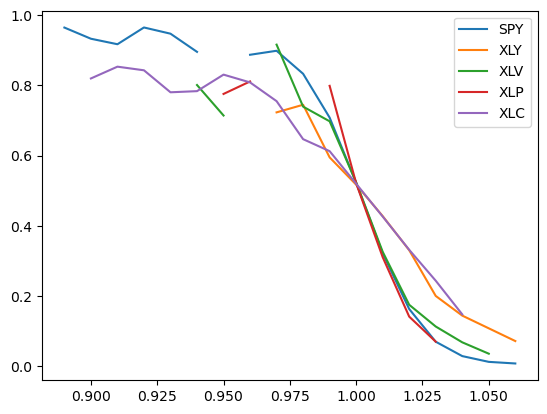

In [66]:
curve_df.plot()

Functional delta calcs from live data, but the absolute state of it means Ill probably try out a data provider for a month

In [42]:
curve_df['SPY'][:20]

0.75         NaN
0.76         NaN
0.77         NaN
0.78         NaN
0.79         NaN
0.80         NaN
0.81         NaN
0.82         NaN
0.83         NaN
0.84         NaN
0.85         NaN
0.86         NaN
0.87         NaN
0.88         NaN
0.89         NaN
0.90         NaN
0.91         NaN
0.92         NaN
0.93         NaN
0.94         NaN
0.95    0.905815
0.96    0.900311
0.97         NaN
0.98    0.946187
0.99    0.818352
1.00    0.513063
1.01    0.162822
1.02    0.030054
1.03         NaN
1.04         NaN
1.05         NaN
1.06         NaN
1.07         NaN
1.08         NaN
1.09         NaN
1.10         NaN
1.11         NaN
1.12         NaN
1.13         NaN
1.14         NaN
1.15         NaN
1.16         NaN
1.17         NaN
1.18         NaN
1.19         NaN
1.20         NaN
1.21         NaN
1.22         NaN
1.23         NaN
1.24         NaN
1.25         NaN
Name: SPY, dtype: float64